# Setup

In [1]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

2024-07-25 19:56:27.710145: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 19:56:27.712298: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 19:56:27.720445: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 19:56:27.733544: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 19:56:27.737756: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-25 19:56:27.746617: I tensorflow/core/platform/cpu_feature_gu

In [3]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [20]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [Errno 17] File exists: 'data/positive'

# Collecting data

## Negative images

Images has a size of 250x250 pixels

In [5]:
for directory in  os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## Positive and Anchor images

In [4]:
# Used to give unique name to our images
import uuid

In [5]:
# Accessing our webcam
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    
    # Adjusting to 250x250 pixels
    frame = frame[115:115+250, 195:195+250, :]
    
    # Collect Anchors
    if cv2.waitKey(1) & 0xFF == ord('a'):
        img_name = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(img_name, frame)
        
    # Collect Positives
    if cv2.waitKey(1) & 0xFF == ord('p'):
        img_name = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(img_name, frame)

    cv2.imshow('Image Collection', frame)
    # Code to quit web cam
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

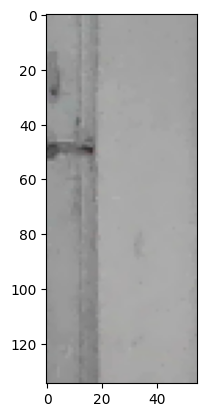

In [6]:
plt.imshow(frame[115:115+250, 195:195+250, :])

In [7]:
frame.shape

(250, 250, 3)

# Preprocessing Data

In [4]:
# loading image paths
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(500)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(500)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(500)

I0000 00:00:1721917599.937002   36882 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-25 19:56:39.942353: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
dir_test = anchor.as_numpy_iterator()

In [12]:
dir_test.next()

b'data/anchor/d6ec2639-4a4f-11ef-a328-39c96ec51708.jpg'

In [5]:
def preprocess(file_path):
    # Loading image
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    # Resizing image
    img = tf.image.resize(img, (105, 105))
    # Scaling image
    img = img / 255
    return img

In [6]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [7]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [8]:
# Run this only once
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [9]:
# training partition
train_data = data.take(round(len(data) * 0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [10]:
# testing Partition
test_data = data.skip(round(len(data) * 0.7))
test_data = test_data.take(round(len(data) * 0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Building the Model

## Using keras functional api

In [11]:
def make_embedding():
    inp = Input(shape = (105, 105, 3), name = 'input_image')
    # First conv layer 
    c1 = Conv2D(64, (10, 10), activation = 'relu')(inp)
    m1 = MaxPooling2D(64, (2, 2), padding = 'same')(c1)
    # Second conv layer
    c2 = Conv2D(128, (7, 7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding = 'same')(c2)
    # Third conv layer
    c3 = Conv2D(128, (4, 4), activation = 'relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding = 'same')(c3)
    # Fourth conv layer
    c4 = Conv2D(256, (4, 4), activation = 'relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = 'sigmoid')(f1)
    
    return Model(inputs = [inp], outputs = [d1], name = 'embedding')

In [12]:
embedding = make_embedding()

2024-07-25 19:56:58.822395: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.
2024-07-25 19:56:58.869148: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.
2024-07-25 19:56:58.898431: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.


In [13]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 105, 105, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 42, 42, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 18, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# We inherit from the Layer class of keras
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)
        input_embedding = tf.squeeze(input_embedding, axis=0)  # Remove potential first dimension
        validation_embedding = tf.squeeze(validation_embedding, axis=0)
        return tf.math.abs(input_embedding - validation_embedding)
        
    # def call(self, input_embedding, validation_embeddding):
    #     return tf.math.abs(input_embedding - validation_embeddding)

## Bringing all together

In [18]:
def make_siamese_model():
    # Anchor image 
    input_image = Input(name = 'input_img', shape = (105, 105, 3))
    # Validation image
    validation_image = Input(name = 'validation_img', shape = (105, 105, 3))
    # passing image in the embedding mmodel
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    # Classification layer
    classifier = Dense(1, activation = 'sigmoid')(distances)

    return Model(inputs = [input_image, validation_image], outputs = classifier, name = 'SiameseNetwork')

In [19]:
siamese_model = make_siamese_model()

In [20]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# Training

In [21]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [22]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)

In [24]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model = siamese_model)

# training Step

In [25]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        # getting anchor and pos/neg
        X = batch[:2]
        # getting label
        y = batch[2]
        # forward pass
        yhat = siamese_model(X, training = True)
        # claculate loss 
        loss = binary_cross_loss(y, yhat)
    print(loss)
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    # Calculate updated weights and apply to siamese model  
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

## training loop

In [26]:
def train(data, EPOCHS):
    # loop through epochs 
    for epoch in range(1, EPOCHS + 1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Loop Through each batch
        for idx, batch in enumerate(data): 
            train_step(batch)
            progbar.update(idx + 1)

        # save ccheckpoint
        if epoch % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)


## train model

In [27]:
EPOCHS = 50

In [30]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
43/44 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/stepTensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
44/44 ━━━━━━━━━━━━━━━━━━━━ 443s 10s/step

 Epoch 2/50


2024-07-26 00:04:59.353916: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


44/44 ━━━━━━━━━━━━━━━━━━━━ 370s 8s/step

 Epoch 3/50


2024-07-26 00:11:09.260794: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


44/44 ━━━━━━━━━━━━━━━━━━━━ 382s 9s/step

 Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 365s 8s/step

 Epoch 5/50


2024-07-26 00:23:35.886289: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


44/44 ━━━━━━━━━━━━━━━━━━━━ 340s 8s/step

 Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 316s 7s/step

 Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 319s 7s/step

 Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 319s 7s/step

 Epoch 9/50


2024-07-26 00:45:10.175480: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


44/44 ━━━━━━━━━━━━━━━━━━━━ 321s 7s/step

 Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 320s 7s/step

 Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 320s 7s/step

 Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 319s 7s/step

 Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 319s 7s/step

 Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 320s 7s/step

 Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 320s 7s/step

 Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 321s 7s/step

 Epoch 17/50


2024-07-26 01:27:51.337187: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


44/44 ━━━━━━━━━━━━━━━━━━━━ 319s 7s/step

 Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 320s 7s/step

 Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 319s 7s/step

 Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 320s 7s/step

 Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 320s 7s/step

 Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 321s 7s/step

 Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 319s 7s/step

 Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 323s 7s/step

 Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 319s 7s/step

 Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 321s 7s/step

 Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 320s 7s/step

 Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 316s 7s/step

 Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 314s 7s/step

 Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 322s 7s/step

 Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 319s 7s/step

 Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 322s 7s/step

 Epoch 33/50


2024-07-26 02:53:06.775231: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


44/44 ━━━━━━━━━━━━━━━━━━━━ 318s 7s/step

 Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 315s 7s/step

 Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 315s 7s/step

 Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 315s 7s/step

 Epoch 37/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 323s 7s/step

 Epoch 38/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 320s 7s/step

 Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 317s 7s/step

 Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 316s 7s/step

 Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 315s 7s/step

 Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 316s 7s/step

 Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 321s 7s/step

 Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 334s 8s/step

 Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 322s 7s/step

 Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 321s 7s/step

 Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 321s 7s/step

 Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 321s 7s/step

 Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 321s 7s/step

 Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 333s 8s/step


# Evaluate Model

In [29]:
from tensorflow.keras.metrics import Precision, Recall

In [31]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [40]:
test_var = test_data.as_numpy_iterator().next()

In [41]:
# predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


array([[1.0000000e+00],
       [4.8288156e-09],
       [1.0000000e+00],
       [1.8806478e-08],
       [2.9671733e-06],
       [9.9999923e-01],
       [7.2744109e-09],
       [1.0000000e+00],
       [9.9998748e-01],
       [3.4645382e-07],
       [9.9516785e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [4.0685186e-06],
       [9.9973977e-01],
       [1.8565909e-07]], dtype=float32)

In [42]:
# processing the results
res = [1 if prediction > 0.9 else 0 for prediction in y_hat]

In [43]:
y_true

array([1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0.],
      dtype=float32)

In [44]:
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

In [45]:
m = Precision()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

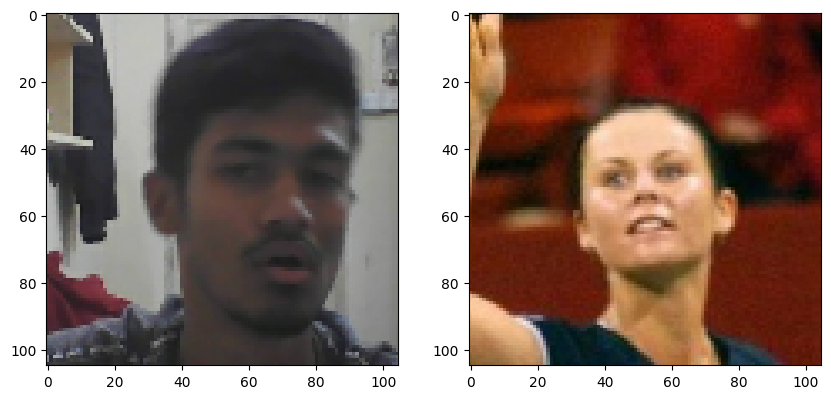

In [48]:
plt.figure(figsize = (10, 8))
plt.subplot(1, 2, 1)
plt.imshow(test_input[1])
plt.subplot(1, 2, 2)
plt.imshow(test_val[1])
plt.show()

# Save Model

In [50]:
# save weigths
siamese_model.save('siamesemodel.h5')

In [57]:
# Reload model
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects = {'L1Dist' :L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})

In [65]:
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


array([[1.0000000e+00],
       [4.8288156e-09],
       [1.0000000e+00],
       [1.8806478e-08],
       [2.9671733e-06],
       [9.9999923e-01],
       [7.2744109e-09],
       [1.0000000e+00],
       [9.9998748e-01],
       [3.4645382e-07],
       [9.9516785e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [4.0685186e-06],
       [9.9973977e-01],
       [1.8565909e-07]], dtype=float32)

In [59]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# Real time verification

In [61]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')): 
        input_img = preprocess(os.path.join('application_data', 'input_images', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

        # make prediction
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis = 1)))
        results.append(result)

    # Detection threshold: Metric above which a prediction is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)

    # Verification threshold : Proportion of positive prediction / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold

    return results, verified

## Capturing images to verify using opencv

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    # Adjusting to 250x250 pixels
    frame = frame[115:115+250, 195:195+250, :]

    cv2.imshow('Verification', frame)

    # verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # save input image
        cv2.imwrite(os.path.join('application_data', 'input_images', 'input_image.jpg'), frame)
        # Run vrification function
        results, verified = verify(model, 0.9, 0.7)
        print(verified) 

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 